In [2]:
!pip install -qq colorama
import os
import shutil
from pathlib import Path
from pprint import pprint
from typing import Dict, List

import colorama

In [3]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *

     |████████████████████████████████| 720 kB 7.7 MB/s 
     |████████████████████████████████| 188 kB 65.3 MB/s 
     |████████████████████████████████| 1.2 MB 56.4 MB/s 
     |████████████████████████████████| 46 kB 5.2 MB/s 
     |████████████████████████████████| 56 kB 5.0 MB/s 
     |████████████████████████████████| 51 kB 450 kB/s 
Mounted at /content/gdrive


In [9]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  ACTORS_DIR = Path("/content/drive/MyDrive/actors")

except ImportError:
  print("WARNING: Google Drive not detected: using local directory instead")
  ACTORS_DIR = Path("actors")

thumb_dir = ACTORS_DIR / "thumbnails"
download_dir = ACTORS_DIR / "download"

Mounted at /content/drive


In [40]:
START_CLEAN = False
# Set to TRUE to clean-up folder when starting

EXPORT_PATH = ACTORS_DIR / "actor_model.pkl"

In [11]:
colorama.init(autoreset=True)

### Storing Azure Key


In [12]:
AZURE_SEARCH_KEY = os.environ.get("AZURE_SEARCH_KEY", (ACTORS_DIR.parent / "AZURE_SEARCH_KEY").read_text())

# Listing top 100 Actors

We will extract a list of actors from IMDB, by using BeautifulSoup.
We will keep a picture of each actor to serve as a test set.

We will also do some sanity checks to verify that we have 100 correct thumbnails.


In [16]:
import requests

from bs4 import BeautifulSoup

URL = "https://www.imdb.com/list/ls050274118/"


In [15]:
# Instead of doing star import :)
from fastai.data.transforms import get_image_files
from fastai.vision.utils import verify_images
from fastdownload.core import download_url

In [17]:
resp = requests.get(URL)
soup = BeautifulSoup(resp.content, 'html.parser')

In [26]:

thumb_dir.mkdir(exist_ok=True, parents=True)

actors_100: List[str] = list()
for img in soup.find_all("img"):
    name = img.get("alt")
    # Name of actors start with an upper case.
    # Otherwise, there is another item: "list image"
    if not name[0].isupper():
        continue
    actors_100.append(name)
    dest = thumb_dir / f"{name}.jpg"
    if not dest.is_file():
      download_url(img.get("src"), dest, show_progress=False)

In [22]:
nb_thumbnails_downloaded = len(list(thumb_dir.glob("*.jpg")))
assert nb_thumbnails_downloaded == 100, f"{nb_thumbnails_downloaded} thumbnails found, 100 expected"
  

In [28]:
actors_thumbs = get_image_files(thumb_dir)
failed_thumbs = verify_images(actors_thumbs)
try:
  assert not failed_thumbs, f"Images corrupted: {failed_thumbs}: please download again"
except AssertionError:
  failed_thumbs.map(Path.unlink)
  raise

# Downloading images for actors

In [21]:
for i, actor in enumerate(actors_100, start=1):
  print(f"#{i:03d}: {actor}")

#001: Jack Nicholson
#002: Marlon Brando
#003: Robert De Niro
#004: Al Pacino
#005: Daniel Day-Lewis
#006: Dustin Hoffman
#007: Tom Hanks
#008: Anthony Hopkins
#009: Paul Newman
#010: Denzel Washington
#011: Spencer Tracy
#012: Laurence Olivier
#013: Jack Lemmon
#014: Michael Caine
#015: James Stewart
#016: Robin Williams
#017: Robert Duvall
#018: Sean Penn
#019: Morgan Freeman
#020: Jeff Bridges
#021: Sidney Poitier
#022: Peter O'Toole
#023: Clint Eastwood
#024: Gene Hackman
#025: Charles Chaplin
#026: Ben Kingsley
#027: Philip Seymour Hoffman
#028: Leonardo DiCaprio
#029: Russell Crowe
#030: Kevin Spacey
#031: Humphrey Bogart
#032: Gregory Peck
#033: Clark Gable
#034: Gary Cooper
#035: George C. Scott
#036: Jason Robards
#037: Charles Laughton
#038: Anthony Quinn
#039: Peter Sellers
#040: James Cagney
#041: Peter Finch
#042: Henry Fonda
#043: Cary Grant
#044: Richard Burton
#045: Burt Lancaster
#046: William Holden
#047: John Wayne
#048: Kirk Douglas
#049: Alec Guinness
#050: Christo

In [34]:
if START_CLEAN:
  shutil.rmtree(download_dir, ignore_errors=True)


for actor in actors_100[:12]:
  dest = download_dir / actor
  # We will only download if we don't have the folder or we have less than 250 pictures in it
  if not dest.is_dir() or len(list(dest.iterdir())) < 250:
    print(f"Downloading images for {actor} in {dest}")
    dest.mkdir(exist_ok=True, parents=True)
    for age in ["young", "old"]:
      results = search_images_bing(AZURE_SEARCH_KEY, f'"{actor}" {age}')
      download_images(dest / f"{actor}_{age}", urls=results.attrgot('contentUrl'))


In [35]:
# As we can have jpg, JPEG, gif, png, ..., we will do a glob based on hierarchy
for img in download_dir.glob("*/*/*.*"):
    actor, age = img.parent.name.split("_")
    actor_dir = img.parent.parent
    assert actor_dir.name == actor, f"{actor_dir} not matching name of actor {actor}"
    img.rename(actor_dir / f"{actor}-{age}-{img.name}")

# We will then check that all files have been copied and clean up directories


In [36]:
for path in download_dir.glob("*/*"):
  if path.is_dir() and path.name.endswith(("_young", "_old")):
    nb_files = len(list(path.glob("*.*")))
    if nb_files:
      print(f"Directory {path} not empty ({nb_files} children)")
    else:
      path.rmdir()
      print(f"Deleted empty directory {path}")

Deleted empty directory /content/drive/MyDrive/actors/download/Marlon Brando/Marlon Brando_young
Deleted empty directory /content/drive/MyDrive/actors/download/Marlon Brando/Marlon Brando_old
Deleted empty directory /content/drive/MyDrive/actors/download/Robert De Niro/Robert De Niro_young
Deleted empty directory /content/drive/MyDrive/actors/download/Robert De Niro/Robert De Niro_old
Deleted empty directory /content/drive/MyDrive/actors/download/Spencer Tracy/Spencer Tracy_young
Deleted empty directory /content/drive/MyDrive/actors/download/Spencer Tracy/Spencer Tracy_old
Deleted empty directory /content/drive/MyDrive/actors/download/Al Pacino/Al Pacino_young
Deleted empty directory /content/drive/MyDrive/actors/download/Al Pacino/Al Pacino_old
Deleted empty directory /content/drive/MyDrive/actors/download/Daniel Day-Lewis/Daniel Day-Lewis_young
Deleted empty directory /content/drive/MyDrive/actors/download/Daniel Day-Lewis/Daniel Day-Lewis_old
Deleted empty directory /content/drive/M

In [37]:
actors_fns = get_image_files(download_dir)
failed = verify_images(actors_fns)


In [ ]:
from collections import defaultdict
corrupted_images_dir = defaultdict(int)
for p in failed:
  corrupted_images_dir[p.parent] += 1

print(f"Cleaning up {len(failed)} corrupted images in {download_dir}:")
for dir_, nb in corrupted_images_dir.items():
  print(f" * {dir_}: {nb:02d} images corrupted")

failed.map(Path.unlink)
print("=> done")

# Learning (CV)

In [13]:
# We reload the name of actors from files download
# (in case we need to restart the Kernel)
actors = [d.name for d in download_dir.glob("*") if d.is_dir()]
len(actors)

20

In [14]:
from fastai.data.block import DataBlock

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


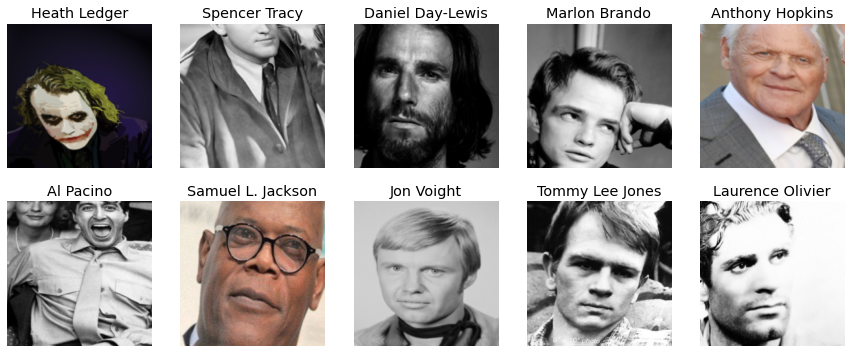

In [15]:
actors_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms(mult=1.25)
)
dls = actors_block.dataloaders(download_dir)
dls.train.show_batch(max_n=10, nrows=2)

In [51]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(20)

epoch,train_loss,valid_loss,error_rate,time
0,3.440252,1.953198,0.578947,01:55


epoch,train_loss,valid_loss,error_rate,time
0,2.361543,1.487079,0.432649,01:58
1,1.967257,1.207665,0.362177,01:58
2,1.641336,1.003898,0.295272,01:58
3,1.297501,0.837383,0.244425,01:59
4,1.027322,0.834512,0.230152,01:59
5,0.834771,0.801801,0.218555,01:58
6,0.687136,0.696082,0.191793,01:58
7,0.543232,0.685189,0.177520,02:01


epoch,train_loss,valid_loss,error_rate,time
0,2.361543,1.487079,0.432649,01:58
1,1.967257,1.207665,0.362177,01:58
2,1.641336,1.003898,0.295272,01:58
3,1.297501,0.837383,0.244425,01:59
4,1.027322,0.834512,0.230152,01:59
5,0.834771,0.801801,0.218555,01:58
6,0.687136,0.696082,0.191793,01:58
7,0.543232,0.685189,0.177520,02:01
8,0.468977,0.747142,0.190901,01:59
9,0.366294,0.702530,0.157895,01:59


In [52]:
interp = ClassificationInterpretation.from_learner(learn)

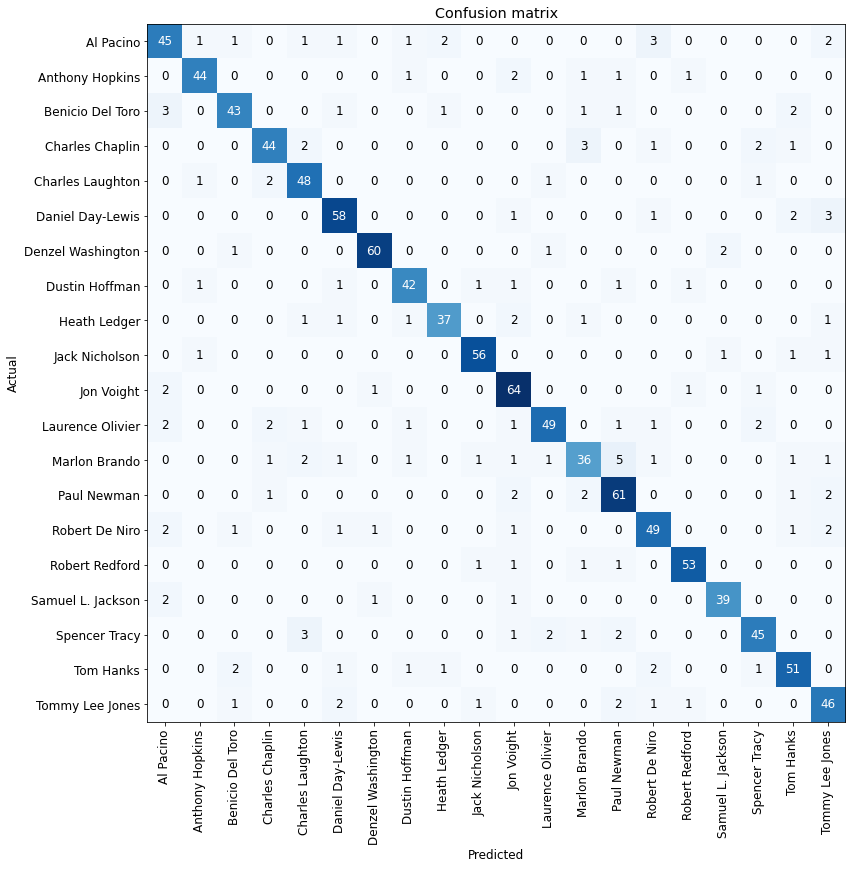

In [53]:
interp.plot_confusion_matrix(figsize=(12, 12))

## Cleaning

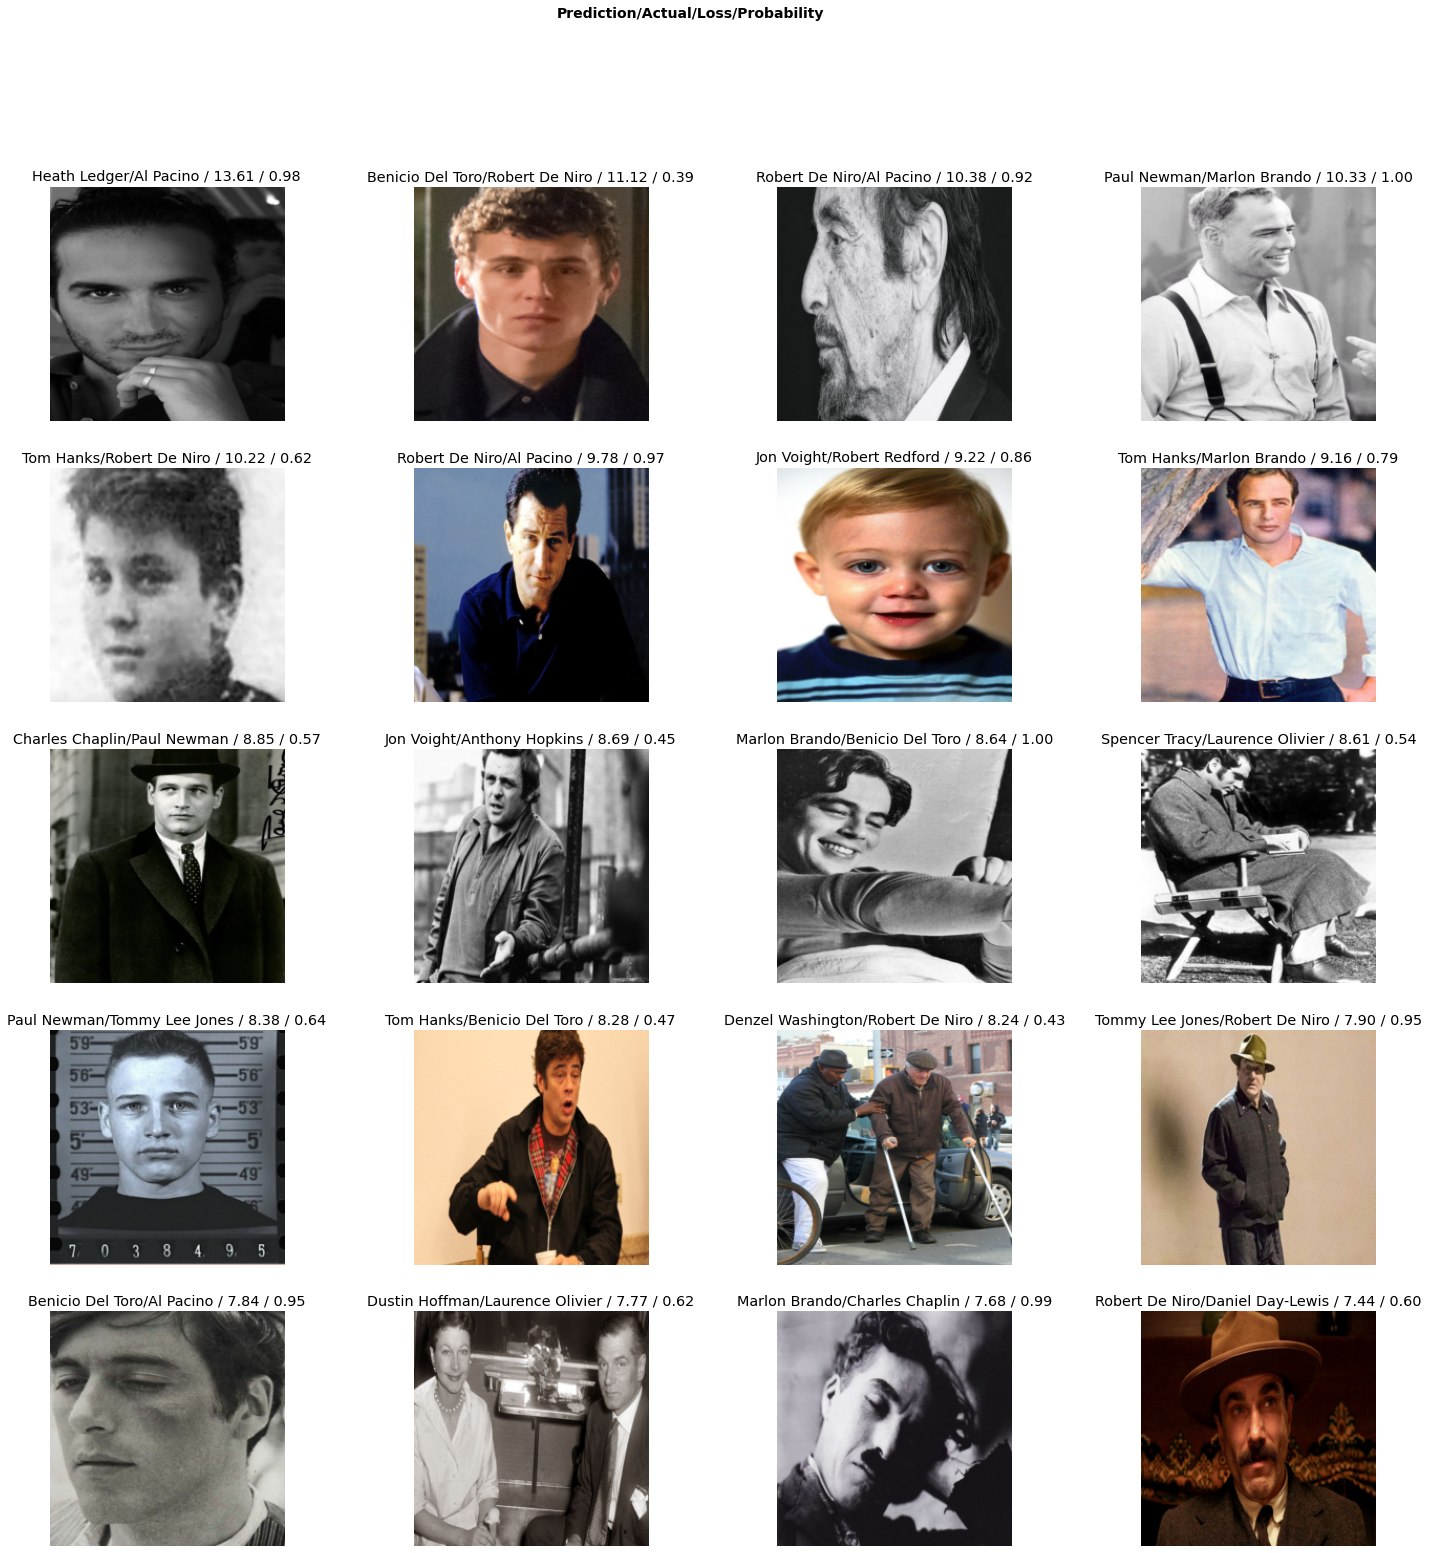

In [54]:
interp.plot_top_losses(20, nrows=5, figsize=(25, 25))

In [23]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [27]:
for idx in cleaner.delete():
  cleaner.fns[idx].unlink()
for idx,cat in cleaner.change():
  shutil.move(str(cleaner.fns[idx]), path/cat)

## Improving Model

## Checking thumbnails

In [55]:
for thumb in thumb_dir.glob("*.jpg"):
  actor = thumb.stem
  if not (download_dir / actor).is_dir():
    continue
  actor_pred, pred_idx, probs = learn.predict(thumb)
  prob_pct = f"{probs[pred_idx] * 100:.2f}%"
  if actor == actor_pred:
    print(f"OK: Correct prediction of '{actor}' (prob: {prob_pct})")
  else:
    print(f"KO: Predicted '{actor}' was '{actor_pred}' with confidence of {prob_pct}")

OK: Correct prediction of 'Jack Nicholson' (prob: 99.99%)


OK: Correct prediction of 'Marlon Brando' (prob: 96.69%)


OK: Correct prediction of 'Robert De Niro' (prob: 100.00%)


OK: Correct prediction of 'Tom Hanks' (prob: 99.95%)


OK: Correct prediction of 'Daniel Day-Lewis' (prob: 99.37%)


OK: Correct prediction of 'Dustin Hoffman' (prob: 100.00%)


OK: Correct prediction of 'Al Pacino' (prob: 99.47%)


OK: Correct prediction of 'Anthony Hopkins' (prob: 100.00%)


OK: Correct prediction of 'Paul Newman' (prob: 99.51%)


OK: Correct prediction of 'Denzel Washington' (prob: 94.23%)


OK: Correct prediction of 'Spencer Tracy' (prob: 99.99%)


OK: Correct prediction of 'Laurence Olivier' (prob: 100.00%)


OK: Correct prediction of 'Charles Chaplin' (prob: 99.96%)


OK: Correct prediction of 'Charles Laughton' (prob: 100.00%)


OK: Correct prediction of 'Tommy Lee Jones' (prob: 97.35%)


OK: Correct prediction of 'Jon Voight' (prob: 99.93%)


OK: Correct prediction of 'Heath Ledger' (prob: 99.99%)


OK: Correct prediction of 'Benicio Del Toro' (prob: 99.98%)


OK: Correct prediction of 'Robert Redford' (prob: 100.00%)


OK: Correct prediction of 'Samuel L. Jackson' (prob: 100.00%)


# Export Model

In [56]:
learn.export(EXPORT_PATH)

# Who are you?

We will re-import the exported model
We will tell you which actor you are closer to (physically) ...

In [57]:
learn_inf = load_learner(EXPORT_PATH)

In [58]:
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

You physically look like Tom Hanks, with a similarity of 80.4%


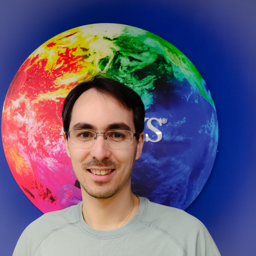

In [60]:
img = PILImage.create(uploader.data[0])
pred, pred_idx, probs = learn_inf.predict(img)
print(f'You physically look like {pred}, with a similarity of {probs[pred_idx] * 100:.1f}%')
display(img.to_thumb(256, 256))